In [840]:
"""
Created on Mon Mar 25 18:00:45 2019

@author: luisgranados
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

house_source_data = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")


# Store the label for the training set. 
house_labels = house_source_data['SalePrice'].copy()

# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Stage the ratings for the mapper function.
# Remember, these are ordinal features.
qual_rating_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                'GarageCond', 'PoolQC']

qual_ordinal_ratings = [
        ('Ex',5), 
        ('Gd',4), 
        ('TA',3), 
        ('Fa',2), 
        ('Po',1), 
        ('NA',0)
    ]

# Exposure features need own mapping.
exposure_rating_feature = ['BsmtExposure']
exposure_ordinal_ratings = [
        ('Gd',4), 
        ('Av',3), 
        ('Mn',2), 
        ('No',1), 
        ('NA',0)
    ]

electrical_rating_feature = ['Electrical']
electrical_ordinal_ratings = [
        ('SBrkr',5),
        ('FuseA',4),
        ('FuseF',3),
        ('FuseP',2),
        ('Mix',1)
    ]

functional_rating_feature = ['Functional']
functional_ordinal_ratings = [
        ('Typ',7), 
        ('Min1',6), 
        ('Min2',5), 
        ('Mod',4), 
        ('Maj1',3),
        ('Maj2',2),
        ('Sev',1),
        ('Sal',0)
    ]

# Finish ratings
bsmt_finish_rating_features = ['BsmtFinType1', 'BsmtFinType2']
bsmtfin_ordinal_ratings = [
        ('GLQ',6), 
        ('ALQ',5), 
        ('BLQ',4), 
        ('Rec',3), 
        ('LwQ',2),
        ('Unf',1),
        ('NA',0)
    ]

grg_finish_rating_feature = ['GarageFinish']
grgfin_ordinal_ratings = [
        ('Fin',3), 
        ('RFn',2), 
        ('Unf',1), 
        ('NA',0)
    ]

paved_rating_feature = ['PavedDrive']
paved_ordinal_ratings = [
        ('Y',2), 
        ('P',1), 
        ('N',0)
    ]

fence_rating_feature = ['Fence']
fence_ordinal_ratings = [
        ('GdPrv',4),
        ('MnPrv',3),
        ('GdWo',2), 
        ('MnWw',1),
        ('NA',0)
    ]

alley_rating_feature = ['Alley']
alley_ordinal_ratings = [
        ('Pave',2),
        ('Grvl',1),
        ('NA',0)
    ]

utilities_rating_feature = ['Utilities']
utilities_ordinal_ratings = [
        ('AllPub',3),
        ('NoSewr',2),
        ('NoSeWa',1),
        ('ELO', 0)
    ]

# Select categorical features to one-hot-encode.
categorial_onehot_features = ['MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'
    ]

selected_categorical_onehot = [
    'MSZoning',
    'Street',
    #'LandContour',
    #'LotConfig',
    #'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    #'BldgType', # might still keep this one
    'HouseStyle',
    'RoofStyle',
    #'RoofMatl',
    'Exterior1st',
    #'Exterior2nd', #might keep this
    #'MasVnrType',
    #'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'      
]

# Use this function for generating new ones. I can't generalize this part 
# because of all the potentially different ways to create each feature.
# but this will allow me to do the same generation for the test set.
def generator(dataframe):
    """Generate new features."""
    new_dataframe = dataframe.copy()
    
    #new_dataframe['LotArea_sqrd'] = new_dataframe['LotArea']**2
    
    new_dataframe['yard_size'] = new_dataframe['LotArea'] - (new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    new_dataframe['yard_size_sqrd'] = new_dataframe['yard_size']**2
    
    new_dataframe['yard_size_cubed'] = new_dataframe['yard_size']**3
    
    new_dataframe['YearBuilt_sqrd'] = new_dataframe['YearBuilt']**2
    
    new_dataframe['YearBuilt_cubed'] = new_dataframe['YearBuilt']**3
    
    new_dataframe['total_sqft'] = (new_dataframe['2ndFlrSF'] + new_dataframe['TotalBsmtSF'] + 
                                   new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    #new_dataframe['total_sqft_sqrd'] = new_dataframe['total_sqft']**2
    
    #new_dataframe['total_sqft_cubed'] = new_dataframe['total_sqft']**3
    
    new_dataframe['liv_area_interaction'] = new_dataframe['GrLivArea'] * new_dataframe['total_sqft']
    
    new_dataframe['liv_area_interaction_sqrd'] = new_dataframe['liv_area_interaction']**2
    
    #new_dataframe['liv_area_interaction_cubed'] = new_dataframe['liv_area_interaction']**3
    
    new_dataframe['housesqft_qual_inter'] = new_dataframe['total_sqft'] * new_dataframe['OverallQual']
    
    new_dataframe['OverallCond_Qual_inter'] = new_dataframe['OverallCond'] * new_dataframe['OverallQual']
    
    new_dataframe['Garage_sqft_sqrd'] = new_dataframe['GarageArea']**2
    
    #new_dataframe['Garage_sqft_cubed'] = new_dataframe['GarageArea']**3
    
    new_dataframe['Garage_CQ_inter'] = (new_dataframe['GarageQual'] * new_dataframe['GarageCond'] *
                                       new_dataframe['GarageCars'] * new_dataframe['GarageArea'])
    
    new_dataframe['Outdoor_lounging'] = (new_dataframe['EnclosedPorch'] + new_dataframe['OpenPorchSF'] * 
                                         new_dataframe['WoodDeckSF'] + new_dataframe['3SsnPorch'] +
                                         new_dataframe['ScreenPorch'])
    
    #new_dataframe['Outdoor_lounging_sqrd'] = new_dataframe['Outdoor_lounging']**2
    
    #new_dataframe['Outdoor_lounging_cubed'] = new_dataframe['Outdoor_lounging']**3
    
    new_dataframe['outdoor_inter'] = new_dataframe['Outdoor_lounging'] * new_dataframe['yard_size']
    
    #new_dataframe['RoomQual_inter'] = new_dataframe['TotRmsAbvGrd'] * new_dataframe['OverallQual']
    
    #new_dataframe['BedroomAbvGr_sqrd'] = new_dataframe['BedroomAbvGr']**2
    
    #new_dataframe['BedroomAbvGr_cubed'] = new_dataframe['BedroomAbvGr']**3
    
    new_dataframe['Exter_inter'] = new_dataframe['ExterCond'] * new_dataframe['ExterQual'] * new_dataframe['MasVnrArea']
 
    new_dataframe['KitchenAbvGr_sqrd'] = new_dataframe['KitchenAbvGr']**2
    
    new_dataframe['kitchen_inter'] = new_dataframe['KitchenAbvGr'] * new_dataframe['KitchenQual']
    
    new_dataframe['bsmt_qual_inter'] = (new_dataframe['BsmtQual'] * new_dataframe['BsmtCond'] * 
                                        new_dataframe['TotalBsmtSF'])

    new_dataframe['BsmtQual_sqrd'] = new_dataframe['BsmtQual']**2
    
    new_dataframe['BsmtQual_cubed'] = new_dataframe['BsmtQual']**3
    
    new_dataframe['BsmtUnfSF_sqrd'] = new_dataframe['BsmtUnfSF']**2
    
    new_dataframe['BsmtUnfSF_cubed'] = new_dataframe['BsmtUnfSF']**3
    
    new_dataframe['BsmtFinSF2_sqrd'] = new_dataframe['BsmtFinSF2']**2
    
    new_dataframe['BsmtFinSF2_cubed'] = new_dataframe['BsmtFinSF2']**3
    
    #new_dataframe['bath_inter'] = (new_dataframe['OverallCond'] * new_dataframe['FullBath'] *
    #                              new_dataframe['OverallQual'])
    
    new_dataframe['fireplace_inter'] = new_dataframe['Fireplaces'] * new_dataframe['FireplaceQu']
    
    return new_dataframe

def mapper(data_in, features, ratings):
    """Map ordinal ratings to numeric ranking."""
    counter = 0
    for feature in features:
        ordinal_mapping = [{
            "col":feature,    
            "mapping": ratings},
        ]

        encoder = ce.OrdinalEncoder(mapping = ordinal_mapping, 
                                    return_df = True, cols = feature)
        if counter == 0:
            df_train = encoder.fit_transform(data_in.copy())
        else:
            df_train = encoder.fit_transform(df_train)
        counter += 1
    return df_train

def data_staging(data_in):
    """Create preliminary training set."""
    data_frame = data_in.copy()
    
    # Fill in the null values with None.
    category_data = data_frame.copy().select_dtypes(exclude='number').fillna(value='None')

    # Fill in null values with 0.
    numeric_data = (data_frame
             .loc[:, data_frame.copy().columns != 'LotFrontage']
             .select_dtypes(include='number')
             .fillna(value=0)
            )

    # Re-merge the two datasets. Drop label and unneeded features.
    data_in_cleaned = (category_data
                         .merge(numeric_data, how='outer',
                                left_index=True, right_index=True)
                         .drop(columns=['SalePrice', 'MiscFeature', 'Id'], errors='ignore')
                        )
    data_in_cleaned = pd.concat([data_in_cleaned, data_in['LotFrontage']], axis=1)
    
    data_in_cleaned = mapper(data_in_cleaned, qual_rating_features, qual_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, bsmt_finish_rating_features, bsmtfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, exposure_rating_feature, exposure_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, electrical_rating_feature, electrical_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, functional_rating_feature, functional_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, grg_finish_rating_feature, grgfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, paved_rating_feature, paved_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, fence_rating_feature, fence_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, alley_rating_feature, alley_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, utilities_rating_feature, utilities_ordinal_ratings)
    
    # Generate new features.
    data_in_cleaned = generator(data_in_cleaned)
    
    return data_in_cleaned

# Create the preliminary training set. This is for analysis.
# numeric attributes get pulled from here.

features_to_drop = ['MoSold', 'YrSold', 'BsmtFinType2', '3SsnPorch', 'BsmtFinSF2',
                   'BsmtHalfBath', 'PoolArea', 'ExterCond', 'MiscVal',
                   'LowQualFinSF', 'OverallCond', 'Alley', 'EnclosedPorch',
                   'KitchenAbvGr', 'Fence', 'Functional', 'ScreenPorch', 'PoolQC',
                   'BedroomAbvGr', 'BsmtCond', 'BsmtUnfSF', 'Utilities',
                   'GarageYrBlt']

house_train_staging = data_staging(house_source_data.copy()).drop(columns=features_to_drop)
house_test_staging = data_staging(house_test.copy()).drop(columns=features_to_drop)

# Store all the numeric type column names for DataFrameSelector(). 
# MSSubClass gets encoded, so it gets droped from the numeric list of features to process.
numeric_features = list(house_train_staging.select_dtypes(include='number').columns)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), selected_categorical_onehot)
    ])

house_train = preprocessor.fit_transform(house_train_staging.copy())
house_test_data = preprocessor.transform(house_test_staging.copy())

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

seed = 42
np.random.seed(seed)

In [865]:
house_source_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [847]:
house_source_data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [848]:
house_source_data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [853]:
house_source_data['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [854]:
house_source_data['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [855]:
house_source_data['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [857]:
house_source_data['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [856]:
house_source_data['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

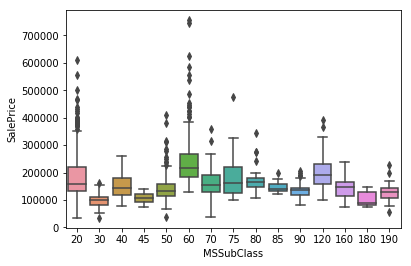

In [862]:
sns.boxplot(house_source_data['MSSubClass'], house_source_data['SalePrice'])

In [864]:
house_source_data[['MSSubClass', 'SalePrice']].loc[house_source_data['MSSubClass']==60].describe()

,MSSubClass,SalePrice
count,299.0,299.000000
mean,60.0,239948.501672
std,0.0,86579.909966
min,60.0,129000.000000
25%,60.0,185000.000000
50%,60.0,215200.000000
75%,60.0,268750.000000
max,60.0,755000.000000


In [889]:
house_source_data.loc[(house_source_data['MSSubClass'] == 20) & (house_source_data['SalePrice'] > 400000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
278,279,20,RL,107.0,14450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,New,Partial,415298
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
473,474,20,RL,110.0,14977,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,New,Partial,440000
496,497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000
515,516,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
664,665,20,RL,49.0,20896,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,New,Partial,423000
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1243,1244,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1373,1374,20,RL,NaN,11400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,466500


In [894]:
a = house_source_data.copy()
a = a.drop([691, 1182, 1169, 803, 897, 898])
a.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1454.000000,1454.000000,1195.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1446.000000,1454.000000,...,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,729.631362,56.891334,69.855230,10486.810867,6.088033,5.577029,1971.162311,1984.813618,101.534578,440.569464,...,93.863136,46.549519,22.044704,3.423659,14.991059,2.388583,43.668501,6.330812,2007.814993,179286.384457
std,422.102852,42.367553,24.105643,9973.758571,1.369899,1.114527,30.213529,20.661305,174.990949,450.904081,...,125.118844,66.290628,61.228893,29.376979,55.672210,37.560994,497.138424,2.700447,1.327675,74249.999014
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,364.250000,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1966.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,728.500000,50.000000,69.000000,9468.500000,6.000000,5.000000,1972.000000,1993.500000,0.000000,382.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162950.000000
75%,1094.750000,70.000000,80.000000,11576.250000,7.000000,6.000000,2000.000000,2004.000000,164.000000,707.500000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213497.500000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,556581.000000


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [94]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [846]:
lasso_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('lasso', Lasso(selection='random', random_state=np.random.seed(seed)))])

lasso_param_grid = {'lasso__alpha' : [10, 50, 90, 100, 110, 300, 400, 500, 600]}

lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=5, n_jobs=-1)

lasso_grid.fit(house_train_staging.copy(), house_labels)

lasso_grid_pred = lasso_grid.best_estimator_.named_steps['lasso'].predict(house_train)

#lasso_rmse = rmsle(house_labels, lasso_grid_pred)

lasso_grid_best = lasso_grid.best_estimator_.named_steps['lasso']

print('Results: {:8f} '.format(lasso_grid.best_score_))

Results: 0.890103 


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [754]:
print('Results: {:8f} '.format(lasso_grid.best_score_))

Results: 0.890355 


In [797]:
lasso_grid.best_params_

{'lasso__alpha': 100}

In [829]:
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('rig', Ridge(random_state=np.random.seed(seed)))])

ridge_param_grid = {'rig__alpha' : [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 5]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=5, n_jobs=-1)

ridge_grid.fit(house_train_staging.copy(), house_labels)

ridge_grid_pred = ridge_grid.best_estimator_.named_steps['rig'].predict(house_train)

ridge_grid_best = ridge_grid.best_estimator_.named_steps['rig']

print('Results: {:8f}'.format(ridge_grid.best_score_))

Results: 0.888014


In [768]:
print('Results: {:8f}'.format(ridge_grid.best_score_))

Results: 0.888014


In [830]:
ridge_grid.best_params_

{'rig__alpha': 0.4}

In [831]:
elastic_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('elastic', ElasticNet(normalize=False,random_state=np.random.seed(seed)))])

elastic_param_grid = {'elastic__alpha' : [0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
                      'elastic__l1_ratio' : [0.85, 0.95, 0.9, 1.0]}

elastic_grid = GridSearchCV(elastic_pipe, param_grid=elastic_param_grid, cv=5, n_jobs=-1)

elastic_grid.fit(house_train_staging.copy(), house_labels)

elastic_grid_pred = elastic_grid.best_estimator_.named_steps['elastic'].predict(house_train)

elastic_rmse = rmsle(house_labels, elastic_grid_pred)

elastic_grid_best = elastic_grid.best_estimator_.named_steps['elastic']

print('Results: {:8f} {:8f}'.format(elastic_grid.best_score_, elastic_rmse))

Results: 0.887370 0.120559


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [820]:
print('Results: {:8f} {:8f}'.format(elastic_grid.best_score_, elastic_rmse))

Results: 0.887232 0.120506


In [832]:
elastic_grid.best_params_

{'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.95}

In [833]:
from sklearn.svm import SVR

svm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('svm', SVR(gamma='scale'))])

svm_param_grid =  {'svm__C' : [ 400000, 470000, 480000, 490000, 500000, 510000],
                   'svm__epsilon' : [ 4000, 5000, 6000, 7000, 8000, 9000]}

svm_grid = GridSearchCV(svm_pipe, param_grid=svm_param_grid, cv=5, n_jobs=-1)

svm_grid.fit(house_train_staging.copy(), house_labels)

svm_grid_pred = svm_grid.best_estimator_.named_steps['svm'].predict(house_train)

svm_rmse = rmsle(house_labels, svm_grid_pred)

svm_grid_best = svm_grid.best_estimator_.named_steps['svm']

print('Results: {:8f} {:8f}'.format(svm_grid.best_score_, svm_rmse))

Results: 0.870421 0.047415


In [676]:
print('Results: {:8f} {:8f}'.format(svm_grid.best_score_, svm_rmse))

Results: 0.877002 0.045552


In [834]:
svm_grid.best_params_

{'svm__C': 490000, 'svm__epsilon': 6000}

In [835]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('rf', RandomForestRegressor(random_state=np.random.seed(seed), n_jobs=-1))])

rf_param_grid =  {'rf__max_depth' : [30, 34, 35, 36, 37, 40],
                   'rf__n_estimators' : [100, 200, 300, 600, 700, 800],
                   'rf__max_features': ['sqrt']}

rf_grid = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)

rf_grid.fit(house_train_staging.copy(), house_labels)

rf_grid_pred = rf_grid.best_estimator_.named_steps['rf'].predict(house_train)

rf_grid_best = rf_grid.best_estimator_.named_steps['rf']

print('Results: {:8f}'.format(rf_grid.best_score_))

/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/extern

Results: 0.879191


In [823]:
print('Results: {:8f}'.format(rf_grid.best_score_))

Results: 0.880365


In [824]:
rf_grid.best_params_

{'rf__max_depth': 35, 'rf__max_features': 'sqrt', 'rf__n_estimators': 700}

In [ ]:
print('Results: {:8f} {:8f}'.format(rf_grid.best_score_, rf_rmse))

In [844]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gbr', GradientBoostingRegressor(random_state=np.random.seed(seed)))])

gbr_param_grid = {'gbr__max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'gbr__n_estimators' : [80, 90, 100, 150 , 200, 250, 300],
                  'gbr__learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
                  'gbr__subsample' : [0.6, 0.7, 0.8, 0.9, 1.0]}

gbr_grid = GridSearchCV(gbr_pipe, param_grid=gbr_param_grid, cv=5, n_jobs=-1)

gbr_grid.fit(house_train_staging.copy(), house_labels)

gbr_grid_pred = gbr_grid.best_estimator_.named_steps['gbr'].predict(house_train)

gbr_grid_best = gbr_grid.best_estimator_.named_steps['gbr']

print('Results: {:8f}'.format(gbr_grid.best_score_))

Results: 0.901642


In [843]:
gbr_grid.best_params_

{'gbr__learning_rate': 0.2,
 'gbr__max_depth': 6,
 'gbr__n_estimators': 100,
 'gbr__subsample': 0.9}

In [ ]:
encoded_features = OneHotEncoder(handle_unknown='ignore').fit(house_train_staging[selected_categorical_onehot]).get_feature_names()

all_features = numeric_features + list(encoded_features)

print(len(all_features))

In [ ]:
['OverallCond', 'MasVnrArea','BsmtFinSF2', 'LowQualFinSF',
 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 
 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'ExterQual', 'ExterCond', 'BsmtQual',
 'BsmtCond', 'HeatingQC', 'KitchenQual', 'Alley', 'BsmtExposure', 'BsmtFinType1',
 'BsmtFinType2', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive',
 'PoolQC', 'Fence', 'Utilities', 'MSSubClass', 'EnclosedPorch']

In [682]:
# Get all the feature importances
importances = list(rf_grid_best.feature_importances_)
encoded_features = OneHotEncoder(handle_unknown='ignore').fit(house_train_staging[selected_categorical_onehot]).get_feature_names()

all_features = numeric_features + list(encoded_features)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(all_features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: housesqft_qual_inter Importance: 0.09
Variable: total_sqft           Importance: 0.08
Variable: OverallQual          Importance: 0.06
Variable: liv_area_interaction Importance: 0.06
Variable: liv_area_interaction_sqrd Importance: 0.06
Variable: Garage_CQ_inter      Importance: 0.04
Variable: bsmt_qual_inter      Importance: 0.04
Variable: KitchenQual          Importance: 0.03
Variable: GrLivArea            Importance: 0.03
Variable: ExterQual            Importance: 0.02
Variable: BsmtQual             Importance: 0.02
Variable: YearBuilt            Importance: 0.02
Variable: TotalBsmtSF          Importance: 0.02
Variable: 1stFlrSF             Importance: 0.02
Variable: GarageCars           Importance: 0.02
Variable: YearBuilt_sqrd       Importance: 0.02
Variable: YearBuilt_cubed      Importance: 0.02
Variable: OverallCond_Qual_inter Importance: 0.02
Variable: Garage_sqft_sqrd     Importance: 0.02
Variable: BsmtQual_sqrd        Importance: 0.02
Variable: BsmtQual_cubed       Im

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_logarithmic_error

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=np.shape(house_train)[1], kernel_initializer='normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset

nn_estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=128, verbose=1)

nn_estimator.fit(house_train, house_labels)

results = cross_val_score(nn_estimator, house_train, house_labels, cv=5, n_jobs =1)
score = nn_estimator.score(house_train, house_labels)
rmse = rmsle(house_labels, nn_estimator.predict(house_train))

print("Results: {:.2f}% ({:.2f}%) {:.5f} {:.5f}".format(results.mean()*100, results.std()*100, score, rmse))

In [845]:
def kaggle_submission(estimator, test_set, test_source, label, kaggle_id):
    """
    Create a csv to submit predictions to Kaggle.
    
    estimator: Sci-kit estimator used on training set.
    test_set: The test set.
    label: The name of the label; must be a string.
    test_source: The original training set, which contains the Id column.
    kaggle_id: The id column from the test set. 
    """
    predictions = estimator.predict(test_set)
    predictions = pd.DataFrame(predictions, columns=[label])
    submission = pd.DataFrame(test_source[kaggle_id])
    submission[label] = predictions[label]
    return submission

predictions = kaggle_submission(gbr_grid_best, house_test_data, 
                                house_test, 'SalePrice', 'Id')

predictions.to_csv('gbr_reduced_with_featuring_submission.csv', index=False)